In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

C:\Users\Aman Agarwal\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv( 'driving_log.csv', names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\center_2019_03_16_22_34_25_673.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\left_2019_03_16_22_34_25_673.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\right_2019_03_16_22_34_25_673.jpg,0.0,0.0,0,0.000078
1,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\center_2019_03_16_22_34_25_775.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\left_2019_03_16_22_34_25_775.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\right_2019_03_16_22_34_25_775.jpg,0.0,0.0,0,0.000078
2,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\center_2019_03_16_22_34_25_880.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\left_2019_03_16_22_34_25_880.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\right_2019_03_16_22_34_25_880.jpg,0.0,0.0,0,0.000078
3,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\center_2019_03_16_22_34_25_983.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\left_2019_03_16_22_34_25_983.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\right_2019_03_16_22_34_25_983.jpg,0.0,0.0,0,0.000080
4,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\center_2019_03_16_22_34_26_089.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\left_2019_03_16_22_34_26_089.jpg,C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\right_2019_03_16_22_34_26_089.jpg,0.0,0.0,0,0.000079


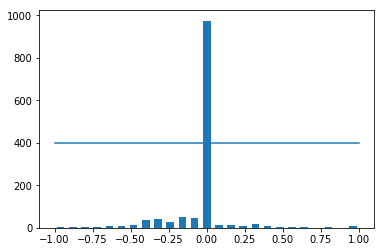

In [13]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [14]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 1309
removed: 575
remaining: 734


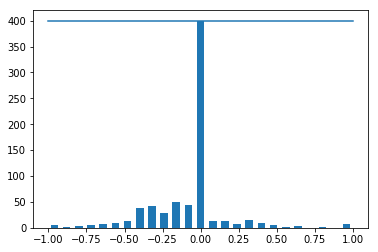

In [15]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [16]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering('\IMG', data)

center      C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\center_2019_03_16_22_34_25_775.jpg
left         C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\left_2019_03_16_22_34_25_775.jpg 
right        C:\Users\Aman Agarwal\Desktop\courses\ML deep learning\practice\self driving\IMG\right_2019_03_16_22_34_25_775.jpg
steering    0                                                                                                                  
throttle    0                                                                                                                  
reverse     0                                                                                                                  
speed       7.80846e-05                                                                                                        
Name: 1, dtype: object


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1761
Valid Samples: 441


Text(0.5,1,'Validation set')

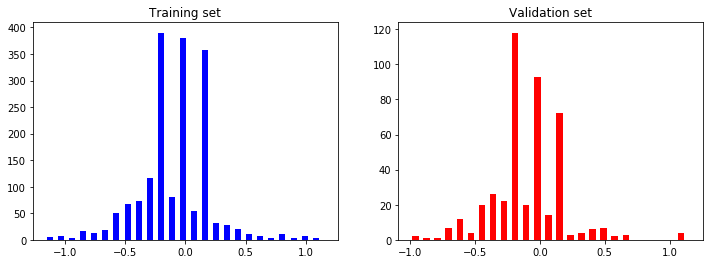

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [19]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img , cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,(3,3),0)
    img = cv2.resize(img,(200,66))
    img = img/255
    return img

In [20]:
image = image_paths[101]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

Text(0.5,1,'processed')

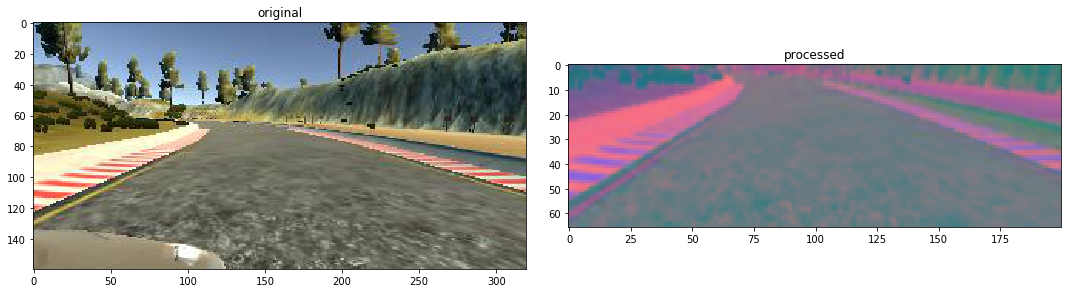

In [21]:
fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("original")
axs[1].imshow(preprocessed_image)
axs[1].set_title("processed")

In [22]:
X_train = np.array(list(map(img_preprocess,X_train)))
X_vaid = np.array(list(map(img_preprocess,X_valid)))

In [23]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
  
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
  
  
    model.add(Flatten())
  
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
    model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

    model.add(Dense(1))
  
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [24]:
model = nvidia_model()
print(model.summary())

C:\Users\Aman Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aman Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
C:\Users\Aman Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
C:\Users\Aman Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
C:\Users\Aman Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `C

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [25]:
print(X_train.shape)

(1761, 66, 200, 3)


In [27]:
history = model.fit(X_train,y_train,epochs = 30,batch_size = 100,verbose = 1,shuffle =1)

Epoch 1/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0403
Epoch 2/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0398
Epoch 3/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0396
Epoch 4/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0376
Epoch 5/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0360
Epoch 6/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0390
Epoch 7/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0353
Epoch 8/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0352
Epoch 9/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0348
Epoch 10/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0329
Epoch 11/30
1761/1761 [==============================] - 14s 8ms/step - loss: 0.0338
Epoch 12/30
1761/1761 [==============================] - 14s 8ms/step - lo

In [28]:
model.save("model.h5")

In [2]:
import imgaug

ImportError: cannot import name '_validate_lengths'